## Fetch the Data

In [1]:
import os
import pandas as pd
import panel as pn
from IPython.display import display, Markdown

import numpy as np
import plotly.express as px
import plotly.graph_objects as go

from numpy import interp

# Load Panel extension
pn.extension(design="material")

# Function to display Markdown content
def printmd(string):
    display(Markdown(string))

# Define the base folder path
base_folder_path = 'C:/Users/emrah/Documents/000MasterLocal/001 Raman/001DataParse/000_DataFromMatlab/'

# Function to read and concatenate data from 'average.txt' in 'average' subfolders
def concat_data_from_average_folders(base_path):
    all_dataframes = []

    # Keep track of unique 'Name' values
    unique_names = set()

    # Iterate over folders in the base path
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name, 'average/')

        # Check if the path is a directory
        if os.path.isdir(folder_path):
            # Look for 'average.txt' file in the 'average' subfolder
            file_path = os.path.join(folder_path, 'average.txt')

            if os.path.exists(file_path):
                # Read data from 'average.txt'
                data = pd.read_csv(file_path, delimiter='\s+', header=0)                

                # Check if 'Name' column exists in the DataFrame
                if 'Name' in data.columns:
                    # Convert 'Name' to lowercase for case-insensitive grouping
                    data['Name'] = data['Name'].str.lower()

                    # Filter out rows with duplicate 'Name' values
                    data = data[~data['Name'].isin(unique_names)]

                    # Add the unique 'Name' values to the set
                    unique_names.update(data['Name'])

                all_dataframes.append(data)
            else:
                print(f"No 'average.txt' file found in folder: {folder_name}")

    if all_dataframes:
        # Concatenate all DataFrames if any are found
        merged_data = pd.concat(all_dataframes, ignore_index=True)
        return merged_data
    else:
        print("No 'average.txt' files found in 'average' subfolders.")
        return None

# Concatenate data from 'average.txt' in 'average' subfolders
result_data = concat_data_from_average_folders(base_folder_path)

# Create a Panel DataFrame widget for interactive sorting with fit_columns set to True
df_widget = pn.widgets.DataFrame(
    result_data,
    name="Average Table",
    sizing_mode="stretch_width",
    show_index=False,
    fit_columns=True
)

# Display the title using Markdown
printmd("### Average Table")

# Display the Panel DataFrame widget
# df_widget

### Average Table

### Second Check for duplicates

In [2]:
def dropDupNaN(df, column_name):
    """
    Drops duplicates and NaN values from a specific column in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the column.
    - column_name (str): The name of the column to process.

    Returns:
    - pd.DataFrame: A DataFrame with duplicates and NaN values removed.
    """
    if df[column_name].duplicated().sum() > 0:
        num_duplicates = df[column_name].duplicated().sum()
        print(f"Number of duplicates in '{column_name}' column: {num_duplicates}")

        # Create a cleaned DataFrame without duplicates and NaN values
        cleaned_df = (
            df.drop_duplicates(subset=[column_name])
            .dropna(subset=[column_name])
            .reset_index(drop=True)
        )

        print("Duplicates and NaN are removed")
        return cleaned_df
    else:
        print(f"There are no duplicates in '{column_name}' column.")
        return df


# Example usage:
result_data = dropDupNaN(result_data, "2DtoG")

Number of duplicates in '2DtoG' column: 1
Duplicates and NaN are removed


### Sort by Name and Reindex data

to reindex the DataFrame after sorting based on the "Name" column, you can use the following code:

In [3]:
# Sort the DataFrame by the "Name" column
result_data = result_data.sort_values(by="Name")

# Reindex the DataFrame
result_data = result_data.reset_index(drop=True)

# Display the sorted and reindexed DataFrame
# result_data

## Define Equations and Boundaries

### Categories
Define the categories so that they can be used later to define marker types in the plot.

In [4]:
# Function to categorize the process and assign marker style
def categorize_process(name):
    if 'hotac' in name:
        return 'hotac'
    elif 'rtac' in name:
        return 'rtac'
    else:
        return 'other'
    
# Create a new column 'process_category' in the DataFrame
result_data['process_category'] = result_data['Name'].apply(categorize_process)

### Margin
Assing margin amount to plot would be created due to min max data locations plius margin value

In [5]:
markerMargin = 1
min_freq_G = result_data['Freq_G'].min() - markerMargin
max_freq_G = result_data['Freq_G'].max() + markerMargin
min_freq_2D = result_data['Freq_2D'].min() - markerMargin
max_freq_2D = result_data['Freq_2D'].max() + markerMargin

# Extended x values
x_values_extended = np.linspace(min_freq_G, max_freq_G, 10)

### Doping Strain Lines

In [6]:
# Equations for line plots
gridGap = 2
equation_strain = lambda x, i: 2.2 * (i * gridGap + x) - 802.62
equation_doping = lambda x, i: 0.7 * (i * gridGap + x) + 1569.8

# Create gridline plots with a loop
line_plots = []
for i in range(-10, 11):
    line_plots.append(pd.DataFrame({"Freq_G": x_values_extended, "Freq_2D": equation_strain(x_values_extended, i)}))
    line_plots.append(pd.DataFrame({"Freq_G": x_values_extended, "Freq_2D": equation_doping(x_values_extended, i)}))

# Strain line
strainLine = pd.DataFrame({"Freq_G": x_values_extended, "Freq_2D": equation_strain(x_values_extended, 0)})

# Doping Line
dopingLine = pd.DataFrame({"Freq_G": x_values_extended, "Freq_2D": equation_doping(x_values_extended, 0)})

# Create Basic Plot

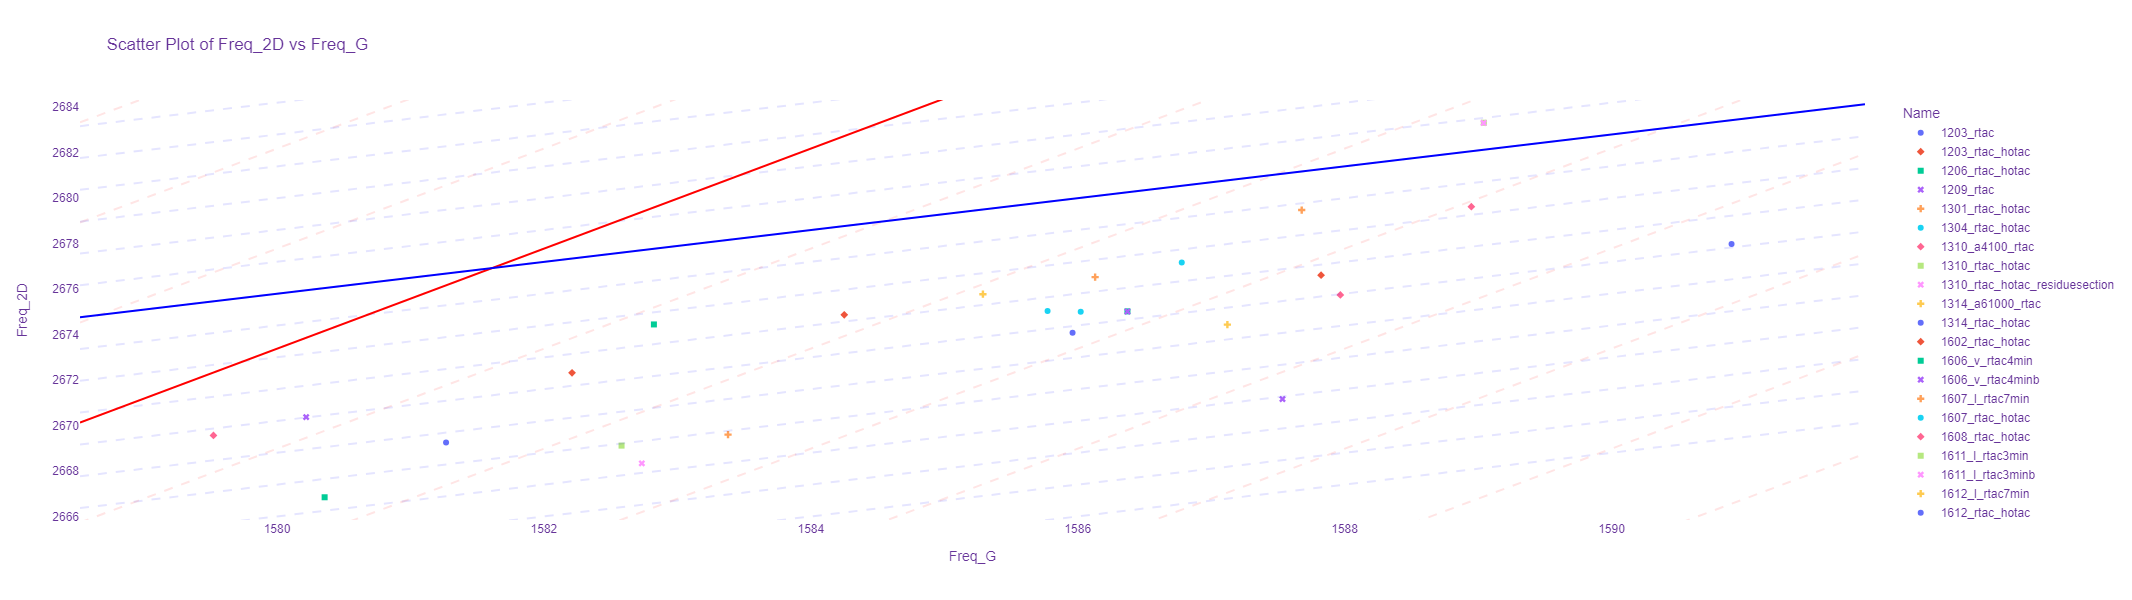

In [9]:
# Scatter plot
main_plot = px.scatter(result_data,x="Freq_G", y="Freq_2D",
                       color="Name",
                       size_max=500,
                       symbol="Name",
                       labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
                       title="Scatter Plot of Freq_2D vs Freq_G",
                       range_x=[min_freq_G, max_freq_G],
                       range_y=[min_freq_2D, max_freq_2D],
                       template="plotly_dark",
                       
)  #  "plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white",

# Add line plots to the scatter plot
for i in range(0, len(line_plots), 2):
    main_plot.add_scatter(x=line_plots[i]['Freq_G'], y=line_plots[i]['Freq_2D'], mode='lines', line=dict(dash='dash', color='red'), opacity=0.1, showlegend=False)
    main_plot.add_scatter(x=line_plots[i + 1]['Freq_G'], y=line_plots[i + 1]['Freq_2D'], mode='lines', line=dict(dash='dash', color='blue'), opacity=0.1, showlegend=False)

# Add solid lines to the scatter plot
main_plot.add_scatter(x=strainLine['Freq_G'], y=strainLine['Freq_2D'], mode='lines', line=dict(dash='solid', color='red'), name='Strain')
main_plot.add_scatter(x=dopingLine['Freq_G'], y=dopingLine['Freq_2D'], mode='lines', line=dict(dash='solid', color='blue'), name='Doping')

# Update layout for a cleaner look
main_plot.update_layout(
    autosize=False,
    width=1000,
    height=600, 
    
    font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(gridcolor='rgb(255, 255, 255)', zerolinewidth=1, ticklen=5, gridwidth=2),
    yaxis=dict(gridcolor='rgb(255, 255, 255)', zerolinewidth=1, ticklen=5, gridwidth=2),
    showlegend=True
)

# Show the plot
#main_plot.show()

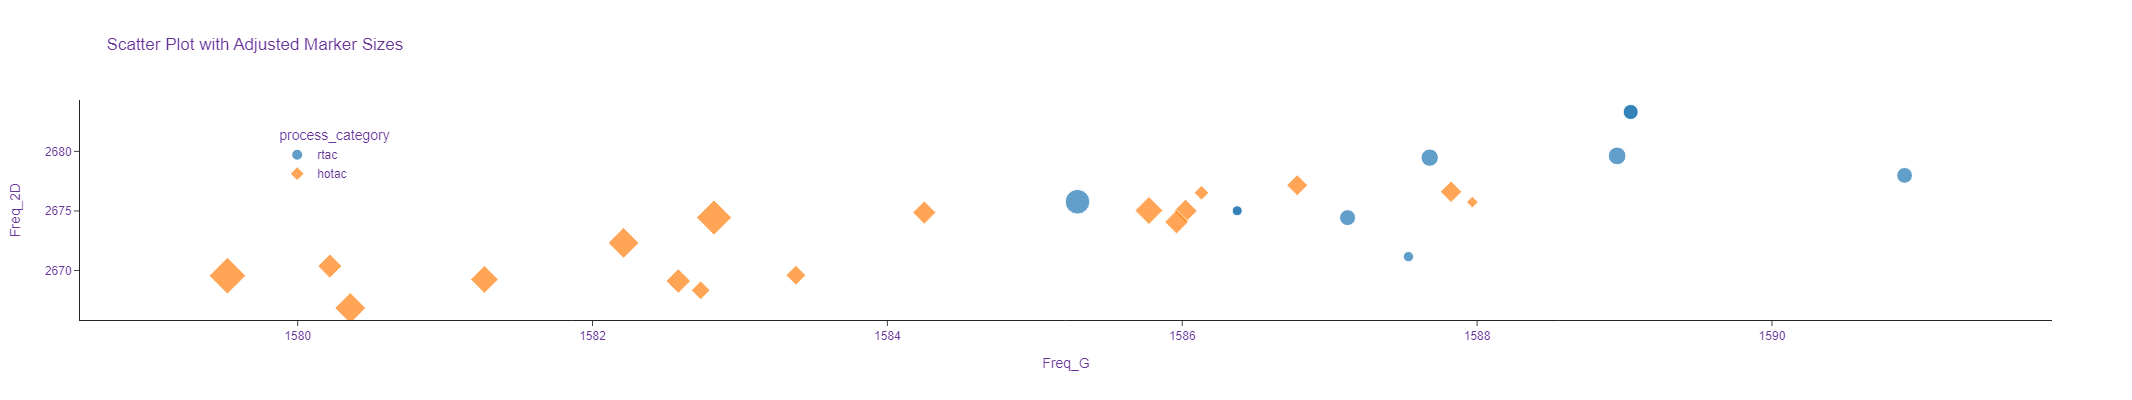

In [10]:
import plotly.express as px

# Assuming 'result_data' is already defined


# Function to scale marker size based on the '2DtoG' ratios
def scale_marker_size(ratios):
    return interp(ratios, [result_data["2DtoG"].min(), result_data["2DtoG"].max()], [10, 100])

result_data["scaled_marker_size"] = scale_marker_size(result_data["2DtoG"])



# Scatter plot with marker sizes based on the scaled '2DtoG' column
main_plot = px.scatter(
    result_data,x="Freq_G",y="Freq_2D",                                  
    # color="2DtoG",
    color="process_category",
    size="scaled_marker_size",
    symbol="process_category",
    labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
    title="Scatter Plot with Adjusted Marker Sizes",
    range_x=[min_freq_G, max_freq_G],
    range_y=[min_freq_2D, max_freq_2D],
    template="simple_white",
    color_continuous_scale="Plasma",
)

# Show the plot
# adjusted_marker_plot.show()

main_plot.update_layout(
    autosize=False,
    width=800,
    height=400,
    font=dict(family="Arial, sans-serif", size=12, color="RebeccaPurple"),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    xaxis=dict(gridcolor="rgb(255, 255, 255)", zerolinewidth=1, ticklen=5, gridwidth=2),
    yaxis=dict(gridcolor="rgb(255, 255, 255)", zerolinewidth=1, ticklen=5, gridwidth=2),
    showlegend=True,
    legend=dict(x=0.1, y=0.9),
)

# Show the plot
# adjusted_marker_plot.show()

In [25]:
import plotly.express as px
import panel as pn
import numpy as np
from scipy.interpolate import interp1d

# Assuming 'result_data' is already defined
pn.extension('plotly')

# Function to scale marker size based on the '2DtoG' ratios
def scale_marker_size(ratios):
    return interp(ratios,[result_data['2DtoG'].min(),result_data['2DtoG'].max()],[10,100])


# Apply the scaling function to the '2DtoG' column to get the marker sizes
result_data['scaled_marker_size'] = scale_marker_size(result_data['2DtoG'])

# Initial color scale
initial_color_scale = "Plasma"


# Panel app
def update_plot(color_scale):
    # Scatter plot with marker sizes based on the scaled '2DtoG' column
    adjusted_marker_plot = px.scatter(
        result_data, x="Freq_G", y="Freq_2D",
        color="2DtoG",
        size="scaled_marker_size",
        symbol="process_category",
        labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
        title="Scatter Plot with Adjusted Marker Sizes",
        range_x=[result_data['Freq_G'].min(), result_data['Freq_G'].max()],
        range_y=[result_data['Freq_2D'].min(), result_data['Freq_2D'].max()],
        
    )

    updated_plot = px.scatter(
        result_data, x="Freq_G", y="Freq_2D",
        color="2DtoG",
        #color="process_category",
        size="scaled_marker_size",
        symbol="process_category",
        labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
        template="simple_white", #['ggplot2', 'seaborn', 'simple_white', 'plotly', 'plotly_white', 'plotly_dark', 'presentation', 'xgridoff', 'ygridoff', 'gridon', 'none']   
        color_continuous_scale=color_scale
    )
    
    return updated_plot

color_scale_dropdown = pn.widgets.Select( options=['Plasma', 'Viridis', 'Magma', 'Magma_r', 'thermal', 
                                                   'balance','balance_r', 'rdbu','rdbu_r', 'portland', 'jet', 'rdylbu', 'turbo',
                                                   'edge', 'icefire', 'aggrnyl', 'agsunset', 'algae',
                                                   'bluered', 'bluyl', 'brbg', 'burgyl', 'cividis', 'curl',
                                                   'deep', 'gray', 'greys', 'haline', 'hot', 'inferno', 
                                                   'magenta', 'matter', 'orrd', 'oxy', 'peach', 'pinkyl', 
                                                   'plotly3', 'rdgy', 'rdpu', 'redor', 'reds', 'solar', 
                                                   'spectral', 'sunset', 'sunsetdark', 'twilight', 'ylorrd'], value=initial_color_scale)



# Define a Panel layout
layout = pn.Row(
    pn.Column('Select Color Scale:', color_scale_dropdown), # Dropdown for color scale
    
)

# Panel callback to update the plot based on the dropdown selection
@pn.depends( color_scale=color_scale_dropdown.param.value)
def update_plot_callback(color_scale):
    return update_plot(color_scale)

# Combine the layout and callback
layout_with_callback = pn.Row(layout, update_plot_callback)

# Show the Panel app
layout_with_callback.servable()

Row(design=<class 'panel.theme.materi...)
    [0] Row(design=<class 'panel.theme.materi...)
        [0] Column(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] Select(design=<class 'panel.theme.materi..., options=['Plasma', 'Viridis', ...], value='Plasma')
    [1] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi...)

In [17]:
import plotly.io as pio
list(pio.templates)  

['ggplot2',
 'seaborn',
 'simple_white',
 'plotly',
 'plotly_white',
 'plotly_dark',
 'presentation',
 'xgridoff',
 'ygridoff',
 'gridon',
 'none']

In [8]:
import plotly.express as px
import panel as pn
import numpy as np
from scipy.interpolate import interp1d

# Assuming 'result_data' is already defined
pn.extension('plotly')

# Function to scale marker size based on the '2DtoG' ratios
def scale_marker_size(ratios):
    return interp(ratios,[result_data['2DtoG'].min(),result_data['2DtoG'].max()],[10,100])


# Apply the scaling function to the '2DtoG' column to get the marker sizes
result_data['scaled_marker_size'] = scale_marker_size(result_data['2DtoG'])

# Initial color scale
initial_color_scale = "Plasma"

# Scatter plot with marker sizes based on the scaled '2DtoG' column
reference_plot = px.scatter(result_data, x="Freq_G", y="Freq_2D",
                                  color="process_category",
                                  size="scaled_marker_size",
                                  symbol="process_category",
                                  labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
                                  title="Scatter Plot with Adjusted Marker Sizes",
                                  range_x=[result_data['Freq_G'].min(), result_data['Freq_G'].max()],
                                  range_y=[result_data['Freq_2D'].min(), result_data['Freq_2D'].max()],
                                  template="simple_white",
                                  color_continuous_scale=initial_color_scale
                                  )

# Panel app
def update_plot(color_scale):
    updated_plot = px.scatter(result_data, x="Freq_G", y="Freq_2D",
                              color="2DtoG",
                              size="scaled_marker_size",
                              symbol="process_category",
                              labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
                              title="Scatter Plot with Adjusted Marker Sizes",
                              range_x=[result_data['Freq_G'].min(), result_data['Freq_G'].max()],
                              range_y=[result_data['Freq_2D'].min(), result_data['Freq_2D'].max()],
                              template="simple_white",
                              color_continuous_scale=color_scale
                              )
    return updated_plot

color_scale_dropdown = pn.widgets.Select(options=['Plasma', 'Magma'], value=initial_color_scale)

# Define a Panel layout
layout = pn.Row(
    pn.Column('Select Color Scale:', color_scale_dropdown), # Dropdown for color scale
    reference_plot,  # Display the initial scatter plot
)

# Panel callback to update the plot based on the dropdown selection
@pn.depends(color_scale=color_scale_dropdown.param.value)
def update_plot_callback(color_scale):
    return update_plot(color_scale)

# Combine the layout and callback
layout_with_callback = pn.Row(layout, update_plot_callback)

# Show the Panel app
layout_with_callback.servable()

Row(design=<class 'panel.theme.materi...)
    [0] Row(design=<class 'panel.theme.materi...)
        [0] Column(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] Select(design=<class 'panel.theme.materi..., options=['Plasma', 'Magma'], value='Plasma')
        [1] Plotly(Figure, design=<class 'panel.theme.materi...)
    [1] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi...)

In [8]:
import plotly.express as px
import panel as pn

# Sample data, replace this with your 'result_data'
result_data = px.data.iris()

pn.extension('plotly')

# Initial title
initial_title = "Initial Title"

# Panel app
def update_plot(selected_title):
    updated_plot = px.scatter(result_data, x="sepal_width", y="sepal_length", title=selected_title)
    return updated_plot

title_dropdown = pn.widgets.Select(options=['Title 1', 'Title 2', 'Title 3'], value=initial_title)

# Panel callback to update the plot title based on the dropdown selection
@pn.depends(selected_title=title_dropdown.param.value)
def update_plot_callback(selected_title):
    return update_plot(selected_title)

# Define a Panel layout
layout_ = pn.Row(pn.Column('Select Title:', title_dropdown), update_plot_callback)

# Show the Panel app
layout_.servable()


Row(design=<class 'panel.theme.materi...)
    [0] Column(design=<class 'panel.theme.materi...)
        [0] Markdown(str, design=<class 'panel.theme.materi...)
        [1] Select(design=<class 'panel.theme.materi..., options=['Title 1', 'Title 2', ...], value='Title 1')
    [1] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi...)

In [99]:
selected_option = title_dropdown.value

# Print or use the selected option
print("Selected Option:", selected_option)

Selected Option: Title 3


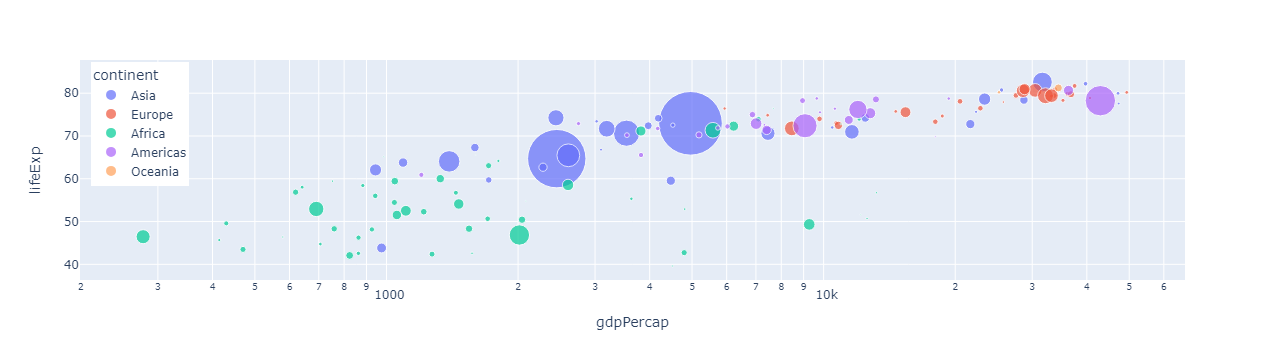

In [26]:
import plotly.express as px

df = px.data.gapminder().query("year==2007")
fig = px.scatter(df, x="gdpPercap", y="lifeExp", color="continent",
    size="pop", size_max=45, log_x=True)

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))

In [9]:
import plotly.express as px
import panel as pn
import numpy as np
from scipy.interpolate import interp1d

# Assuming 'result_data' is already defined
pn.extension('plotly')

# Function to scale marker size based on the '2DtoG' ratios
def scale_marker_size(ratios):
    return interp1d([result_data['2DtoG'].min(), result_data['2DtoG'].max()], [10, 100])(ratios)

# Apply the scaling function to the '2DtoG' column to get the marker sizes
result_data['scaled_marker_size'] = scale_marker_size(result_data['2DtoG'])

# Initial color scale
initial_color_scale = "Plasma"

# Scatter plot function
def create_scatter_plot(color_scale):
    # Scatter plot with marker sizes based on the scaled '2DtoG' column
    scatter_plot = px.scatter(
        result_data, x="Freq_G", y="Freq_2D",
        color="2DtoG",
        size="scaled_marker_size",
        symbol="process_category",
        labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
        title="Scatter Plot with Adjusted Marker Sizes",
        range_x=[result_data['Freq_G'].min(), result_data['Freq_G'].max()],
        range_y=[result_data['Freq_2D'].min(), result_data['Freq_2D'].max()],
    )

    updated_plot = px.scatter(
        result_data, x="Freq_G", y="Freq_2D",
        color="2DtoG",
        size="scaled_marker_size",
        symbol="process_category",
        labels={"Freq_G": "Freq_G", "Freq_2D": "Freq_2D"},
        template="simple_white",
        color_continuous_scale=color_scale
    )

    return updated_plot

# Panel widgets
color_scale_dropdown = pn.widgets.Select(options=['Plasma', 'Viridis', 'Magma', 'Magma_r', 'thermal',
                                                  'balance', 'balance_r', 'rdbu', 'rdbu_r', 'portland', 'jet', 'rdylbu', 'turbo',
                                                  'edge', 'icefire', 'aggrnyl', 'agsunset', 'algae',
                                                  'bluered', 'bluyl', 'brbg', 'burgyl', 'cividis', 'curl',
                                                  'deep', 'gray', 'greys', 'haline', 'hot', 'inferno',
                                                  'magenta', 'matter', 'orrd', 'oxy', 'peach', 'pinkyl',
                                                  'plotly3', 'rdgy', 'rdpu', 'redor', 'reds', 'solar',
                                                  'spectral', 'sunset', 'sunsetdark', 'twilight', 'ylorrd'],
                                       value=initial_color_scale)

# Define a Panel layout
layout = pn.Row(
    pn.Column('Select Color Scale:', color_scale_dropdown),  # Dropdown for color scale
)

# Bind the widgets and the scatter plot function
scatter_plot = pn.bind(create_scatter_plot, color_scale=color_scale_dropdown)

# Combine the layout and the scatter plot
layout_with_plot = pn.Column(layout, scatter_plot)

# Show the Panel app
layout_with_plot.servable()


Column(design=<class 'panel.theme.materi...)
    [0] Row(design=<class 'panel.theme.materi...)
        [0] Column(design=<class 'panel.theme.materi...)
            [0] Markdown(str, design=<class 'panel.theme.materi...)
            [1] Select(design=<class 'panel.theme.materi..., options=['Plasma', 'Viridis', ...], value='Plasma')
    [1] ParamFunction(function, _pane=Plotly, defer_load=False, design=<class 'panel.theme.materi...)